In [1]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
PROCESSED_DATA = os.path.join(ROOT_DIR, 'data/processed')
txt = os.path.join(ROOT_DIR, 'data/processed/keep_img_ids.txt')
sys.path.append(ROOT_DIR)  # To find local version of the library

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import skimage.transform as st
import skimage
import random
import cv2 as cv

from models.maskrcnn.mrcnn import visualize,utils
import helper as hp

IMG_DIR = os.path.join(PROCESSED_DATA, 'images')
LBL_DIR = os.path.join(PROCESSED_DATA, 'segmentations')
MAP_DIR = os.path.join(PROCESSED_DATA, 'disparity_maps')


keeplabels ={'sidewalk':8,
            'rail track':10,
            'wall':12,
            'fence':13,
            'guard rail':14,
            'pole':17,
            'polegroup':18,
            'vegetation': 21,
            'car':26,
            'bicycle':33}
inv_keeplabels =  {
    8: 'sidewalk',
    10: 'rail track',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    17: 'pole',
    18:  'polegroup',
    21: 'vegetation',
    26: 'car',
    33: 'bicycle'}

# Labeling IOUs

Ignroe this mor now
```for all 3277 pics
for all class, generate each instances of mask
    taken care of with the polygon json processing
for each mask, label them 
    id_class_instance-num e.g.
        aachen_000003_000019_sidewalk_001
        aachen_000003_000019_car_001
        ...
    if there are 10 labels: 3 of them sidewalk and 7 of them not sidewalk
        the data for the classifer will be something like
          img-id_sidewalk_instance-id   |   img-id_class_instance-id   |   IOU (not read but calculated)    |  label
```


In [20]:
df = pd.read_csv(os.path.join(PROCESSED_DATA,'labels_obs.csv'),index_col=None)
df.head()
data = df.set_index('ID').T.to_dict('list')
for key, val in data.items():
    labs,obs = val
    labs= np.array([int(i) for i in labs.split(' ')[:-1]])
    obs = np.array([int(i) for i in obs.split(' ')[:-1]])
    data[key] = (labs, obs)
    

## reading sample data
## not too bad of a running time, it takes rougly 3mins to 
## go through all 3277 images
## txt = os.path.join(ROOT_DIR, 'data/processed/keep_img_ids.txt')

# sample 100 images
txt = os.path.join(ROOT_DIR, 'data/processed/sample.txt')
with open(txt) as f:
    sample_ids= f.readlines()

# all the image ids
sample_ids = [i.strip('\n').split('.')[0] for i in sample_ids]

# all instance labels for each id
sample_labels = [data[id] for id in sample_ids]

# # {img_id: all_instance_mask}
# data_mask = {}

# for id in sample_ids[:3]:
#     path_to_mask = os.path.join(LBL_DIR, f'{id}.json')
#     label = data[id][0]
#     masks = hp.create_mask(path_to_mask,label,(256,512))
#     data_mask[id] = masks
#     # np.save(os.path.join(PROCESSED_DATA,'masks',f'{id}.npy'),masks)
    # data[k] = np.array([int(i) for i in data[k]])

[21  8 17 17 17 21 21 26 26 26  8 17 17 17 17 17 26 17 26 17 26 26 26 26
 26 26 26 12 17 21 10 26 33 17 17 17 17 17 17 26 17 17 21 21 21 21 21 21]
[ 8  8  8 26 26 26 21 17 21 17 17 17 17 17 17 17 17 17 26 26 21 26 26 17
 17 26 17 26 17 26 21 26 26 17 26 17 17 26 26 26 17 26 17 17 17 17 33 26
 17 17 17 17]
[ 8 21 26 26 26 26 21 26 21 26 26 17 21 26 26 17 33 26 26 21 26 26 21 21
 26  8 17 17 17 26 21 17 21 17 17 17 21 33 17 21 17 33 33 33 33 33 33 17
 17 33 26 33 33 17 33 33 17 17]


In [52]:
# # reading label data
# df = pd.read_csv(os.path.join(PROCESSED_DATA,'labels.csv'),index_col=None)
# df.head()
# data = df.set_index('ID').T.to_dict('list')
# for k in data:
#     data[k] = [i.split(' ')[:-1] for i in data[k]][0]
#     data[k] = np.array([int(i) for i in data[k]])

## reading sample data
## not too bad of a running time, it takes rougly 3mins to 
## go through all 3277 images
## txt = os.path.join(ROOT_DIR, 'data/processed/keep_img_ids.txt')

# # sample 100 images
# txt = os.path.join(ROOT_DIR, 'data/processed/sample.txt')
# with open(txt) as f:
#     sample_ids= f.readlines()

# # all the image ids
# sample_ids = [i.strip('\n').split('.')[0] for i in sample_ids]

# # all instance labels for each id
# sample_labels = [data[id] for id in sample_ids]

# # {img_id: all_instance_mask}
# data_mask = {}

# for id in sample_ids:
#     path_to_mask = os.path.join(LBL_DIR, f'{id}.json')
#     label = data[id]
#     masks = hp.create_mask(path_to_mask,label,(256,512))
#     data_mask[id] = masks
# #     # np.save(os.path.join(PROCESSED_DATA,'masks',f'{id}.npy'),masks)

In [63]:
id

'darmstadt_000068_000019'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2604


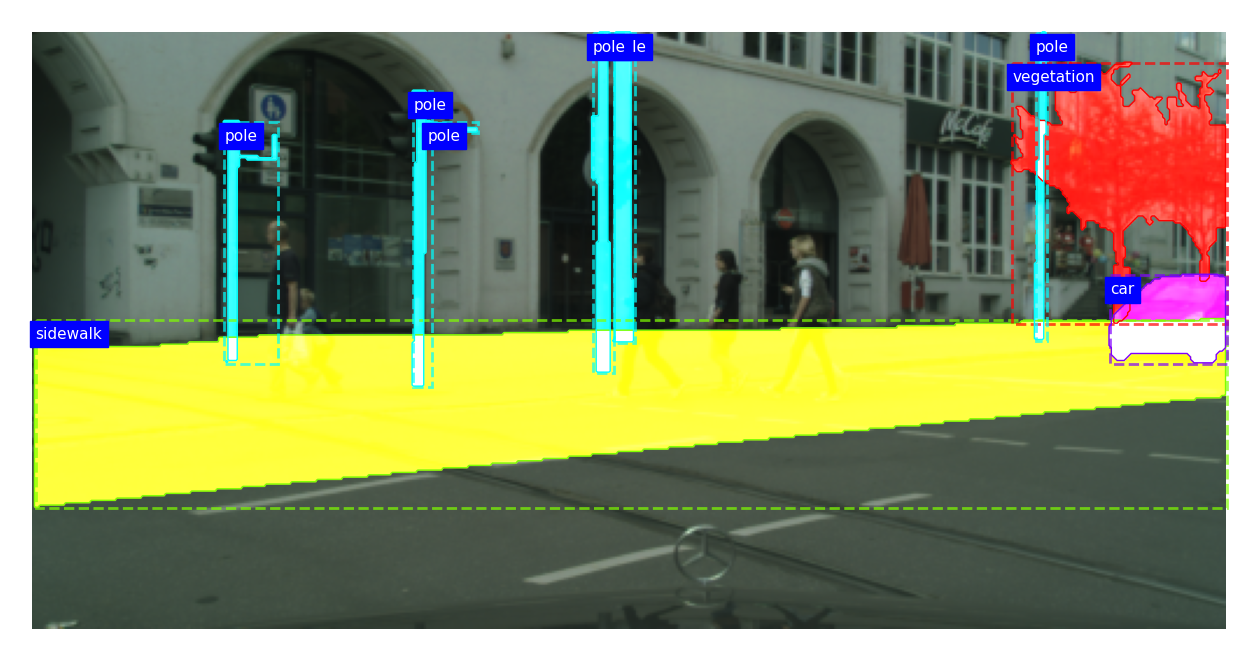

In [64]:

i = random.randint(0,len(data))
dim = (256,512)
labels_dict = {
    8: 'sidewalk',
    10: 'rail track',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    17: 'pole',
    18:  'polegroup',
    21: 'vegetation',
    26: 'car',
    33: 'bicycle'}

# i=71
# i = 32
# i=60
# i=81



id = list(data)[i]
# get the mask and label of this specific i
labels = data[id][0]
obs = data[id][1]
names = [labels_dict[y]for y in labels] #label in plain english

# creating the mask
path_to_mask = os.path.join(LBL_DIR, f'{id}.json')
mask = hp.create_mask(path_to_mask, labels, resize=(256,512) )


rgbimg = plt.imread(f'{IMG_DIR}/{id}.png')
rgbimg = st.resize(rgbimg, dim)


# # # extract all the bounding boxes 
bboxes= utils.extract_bboxes(mask)
print(i)
visualize.display_instances(rgbimg,bboxes,mask,labels,labels_dict)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


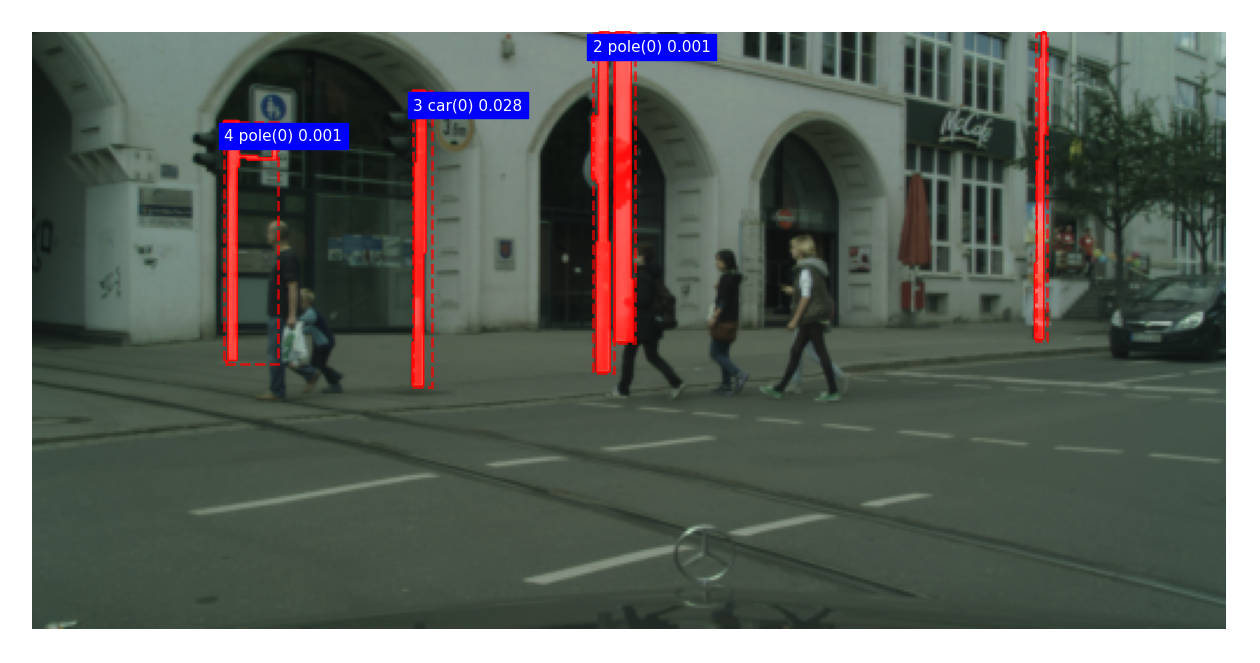

In [65]:
ious = hp.generate_ious(labels, mask) 
captions = hp.generate_captions_obstructed(labels, ious, IOU_THRESHOLD = 0.001)

visualize.display_instances(rgbimg,bboxes[obs>0],mask[:,:,obs>0],labels[obs>0],labels_dict, captions=captions)

# Playing with disparity Values (ignore for now)

In [527]:
#  depth values using the formula: depth = baseline * focal_length / disparity

def disparity_value(d):
    d[d > 0] = (d[d > 0] - 1) / 256
    print(d.min(), d.max())
    return d

def calculate_depth(disparity, baseline, focal_length):
    disparity = disparity_value(disparity)
    mask = (disparity!=0)
    depth = np.empty_like(disparity)
    depth[mask] = (baseline*focal_length)/disparity[mask]
    depth[~mask] = 0
    return depth
import json
def retrieve_camera(filename):
    '''returns baseline and focal length of camera calibration files'''
    with open(filename) as f:
        data = json.load(f)
    return data['extrinsic']['baseline'], data['intrinsic']['fx']
   

In [528]:
calibs = os.path.join(PROCESSED_DATA,'camera_calibrations', sample_ids[i]+'.json')
b,f = retrieve_camera(calibs)

-1.0 -0.5613427
-843.64655 -473.57486


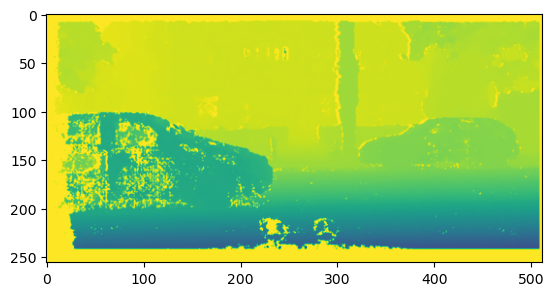

In [529]:
depth = calculate_depth(img,b, f)
print(depth.min(), depth.max())
plt.imshow(depth)

In [531]:

# lets check the disparity values of the bike (40) and sidewalk (9)
car = mask[:,:,8]
sidewalk = mask[:,:,3]

# print(car.shape, sidewalk.shape)
# # plt.imshow(stacked_img[bike])

# # get the depth of the sidewalk and car separately
sidewalk_depth = sidewalk*depth
# sidewalk_depth[sidewalk_depth!=0] = 1/sidewalk_depth[sidewalk_depth!=0]
car_depth = car*depth
# car_depth[car_depth!=0] = 1/car_depth[car_depth!=0]
combo_depth = car*sidewalk*depth


# car_depth * np.logical_not(sidewalk_depth)

car_no_overlap = car * np.logical_not(sidewalk)
sidewalk_no_overlap = sidewalk * np.logical_not(car)
# # car_depth = calculate_depth(car,b,f)
# sidewalk_depth = calculate_depth(sidewalk, b,f)
# combo_depth = calculate_depth(car*sidewalk, b,f)

# print(combo_depth.sum())



# get the depth of the sidewalk * car

In [532]:
# expand the bbox of the masked object 
# by some scale: (proportion of depth)?
# check the depth of that area and depth of th masked object

In [533]:
# comparing if the depth values of the two objects are equal at
# their intersection?
car_idx = (car_no_overlap*depth)!=0
side_idx = (sidewalk_no_overlap*depth)!=0
idx = car_idx
if len(side_idx)>len(car_idx):
    idx = side_idx

c = (car_no_overlap*depth)[idx]
s = (sidewalk_no_overlap*depth)[idx]

np.isclose(c,s).sum()

0

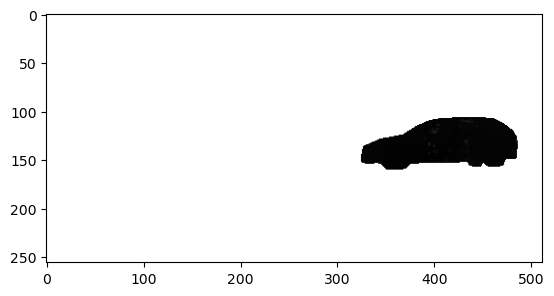

In [534]:
plt.imshow(car_depth, cmap='gray')

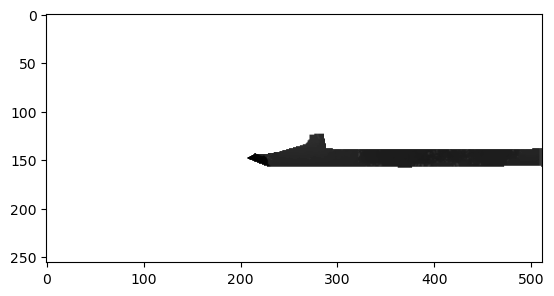

In [535]:
plt.imshow(sidewalk_depth,cmap='gray')

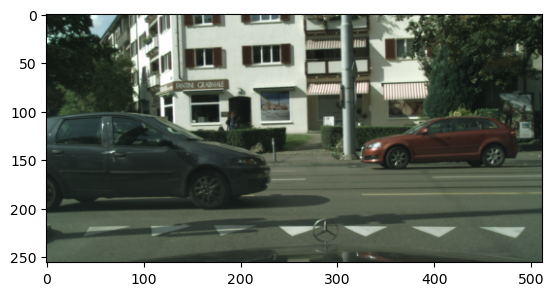

In [536]:
plt.imshow(rgbimg)
# plt.imshow(stacked_img)

# histogram of all the **possible** obstruction data

In [ ]:
## go through all 3277 images
txt = os.path.join(ROOT_DIR, 'data/processed/keep_img_ids.txt')

with open(txt) as f:
    sample_ids= f.readlines()

# all the image ids
sample_ids = [i.strip('\n').split('.')[0] for i in sample_ids]

# all instance labels for each id
sample_labels = [data[id] for id in sample_ids]


# {img_id: all_instance_mask}
data_mask = {}
for id in sample_ids:
    masks = hp.create_mask(id, data,(256,512))
    data_mask[id] = masks

In [ ]:
rand_num = random.sample(range(1,len(sample_ids)),int(0.05*len(sample_ids)))
print(len(rand_num))

In [3]:
img_iou = {}

# for each img
    # get the mask
    # get the label
    # read the img and resize (optional)
    # extract the bounding box (optional don't need for iou)
    # calculate ious
        # objects[i] = iou for all ious 

for i in range(len(rand_num)):
    _id = rand_num[i]
    id  = sample_ids[_id]

    masks = data_mask[id]
    labels = sample_labels[_id]
    
    names = [labels_dict[y] for y in labels]
    
    ious = hp.generate_ious(labels, masks)
    img_iou[id] = ious
        # print(k,v[1])
        # name = labels_dict[labels[k]]
        # if name not in objects:
        #     objects[name] = []

        # objects[name].append(v[1])


NameError: name 'rand_num' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


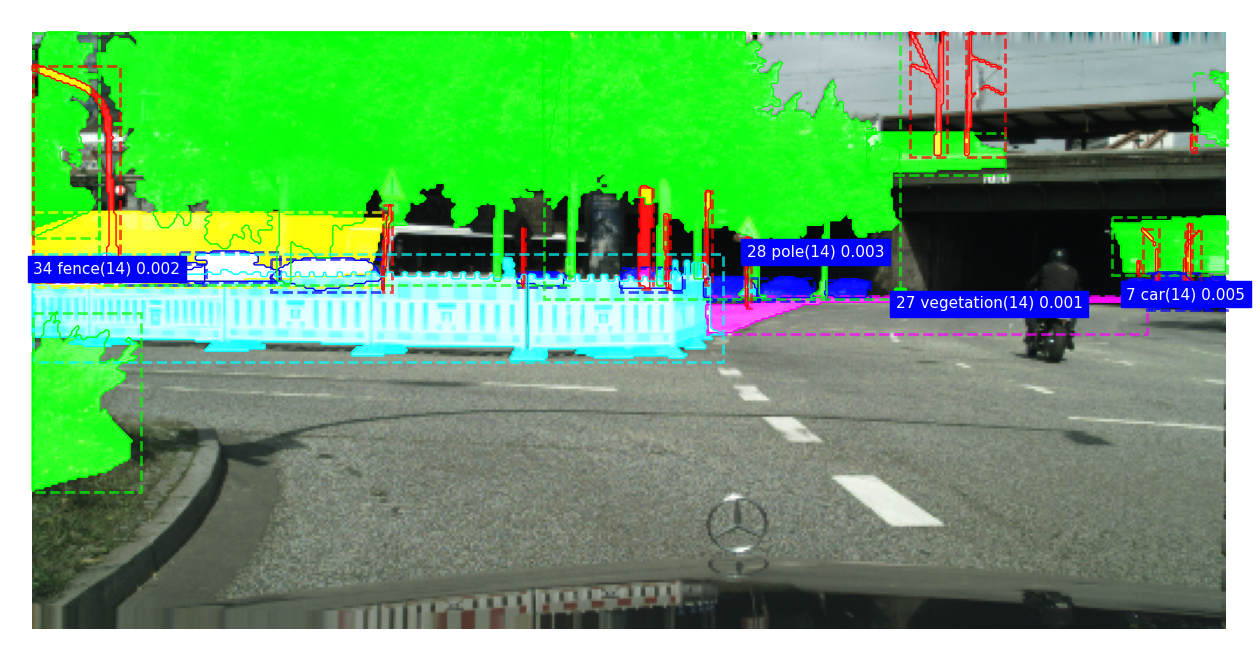

In [77]:
id = 'hamburg_000000_006192'
idx = sample_ids.index(id)
labels = sample_labels[idx]
masks = data_mask[id]

img = plt.imread(PROCESSED_DATA+f'/images/{id}.png')
img = st.resize(img, dim, 0, anti_aliasing=False)

captions = hp.generate_captions_obstructed(labels, img_iou[id])

visualize.display_instances(img, 
                            utils.extract_bboxes(masks),
                            masks,
                            labels,
                            labels_dict,
                             captions=captions )

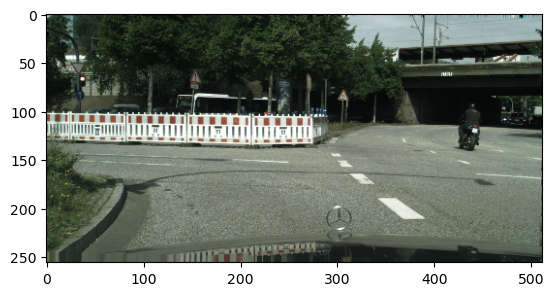

In [79]:
plt.imshow(img)